In [1]:
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from subset_pca import *



from time import time

In [2]:
adult_test_df = pd.read_csv('datasets/benchmark/adult_clean_test.csv')
adult_train_df = pd.read_csv('datasets/benchmark/adult_clean_train.csv')
titanic_test_df = pd.read_csv('datasets/benchmark/titanic_clean_test.csv')
titanic_train_df = pd.read_csv('datasets/benchmark/titanic_clean_train.csv')
weather_test_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_test.csv')
weather_train_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_train.csv')
wine_test_df = pd.read_csv('datasets/benchmark/wine_test.csv')
wine_train_df = pd.read_csv('datasets/benchmark/wine_train.csv')

In [3]:
def extract_X_y(df, col_y):
    X = df.drop(col_y, axis=1)
    y = df[col_y]
    return X, y

In [4]:
adult_test_X, adult_test_y = extract_X_y(adult_test_df, 'income_>50k')
adult_train_X, adult_train_y = extract_X_y(adult_train_df, 'income_>50k')

titanic_test_X, titanic_test_y = extract_X_y(titanic_test_df, 'Survived')
titanic_train_X, titanic_train_y = extract_X_y(titanic_train_df, 'Survived')

weather_test_X, weather_test_y = extract_X_y(weather_test_df, 'RainTomorrow')
weather_train_X, weather_train_y = extract_X_y(weather_train_df, 'RainTomorrow')

wine_test_X, wine_test_y = extract_X_y(wine_test_df, 'quality')
wine_train_X, wine_train_y = extract_X_y(wine_train_df, 'quality')

In [5]:
def df_features_to_dicts(df):
    columns = df.columns
    dicts = []
   
    for index, row in df.iterrows():
        feature_dict = {}
        for col in columns:
            feature_dict[col] = row[col]
        dicts.append(feature_dict)
    return dicts

In [6]:
adult_test_dict_X = df_features_to_dicts(adult_test_X)
adult_train_dict_X = df_features_to_dicts(adult_train_X)

titanic_test_dict_X = df_features_to_dicts(titanic_test_X)
titanic_train_dict_X = df_features_to_dicts(titanic_train_X)

weather_test_dict_X = df_features_to_dicts(weather_test_X)
weather_train_dict_X = df_features_to_dicts(weather_train_X)

wine_test_dict_X = df_features_to_dicts(wine_test_X)
wine_train_dict_X = df_features_to_dicts(wine_train_X)

In [7]:
titanic_train_X.shape

(1047, 20)

In [8]:
titanic_train_y.shape

(1047,)

In [9]:
len(titanic_train_dict_X)

1047

In [10]:
def compute_score(model, test_X, test_y):
    pred = model.predict(test_X)
    acc = accuracy_score(pred, test_y)
    f1 = f1_score(pred, test_y)
    conf = confusion_matrix(pred, test_y)

    return acc, f1, conf

In [11]:
def fit_compute_score(model, train_X, train_y, test_X, test_y):
    t0 = time()
    model.fit(train_X, train_y)
    duration = time() - t0
    train_acc, train_f1, train_conf = compute_score(model, train_X, train_y)
    test_acc, test_f1, test_conf = compute_score(model, test_X, test_y)
#     print("duration", duration)
#     print("train accuracy", train_acc)
#     print("train f1", train_f1)
#     print("train tn, fp, fn, tp", train_conf.ravel()) 
#     print("test accuracy", test_acc)
#     print("test f1", test_f1)
#     print("test tn, fp, fn, tp", test_conf.ravel())
#     print()
    
    return train_acc, train_f1, train_conf, test_acc, test_f1, test_conf

In [12]:
def compare(train_X, train_dict_X, train_y, test_X, test_dict_X, test_y, dataset_name):
    clf_ridge_default = RidgeClassifier()
    # print('ridge_default')
    ridge_default_train_acc, ridge_default_train_f1, ridge_default_train_conf, \
        ridge_default_test_acc, ridge_default_test_f1, ridge_default_test_conf = \
        fit_compute_score(clf_ridge_default, train_X, train_y, test_X, test_y)

    n_estimators = 1000
    clf_randfor_default = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    # print('randfor_default')
    randfor_default_train_acc, randfor_default_train_f1, randfor_default_train_conf, \
        randfor_default_test_acc, randfor_default_test_f1, randfor_default_test_conf = \
        fit_compute_score(clf_randfor_default, train_X, train_y, test_X, test_y)

    ridge_train_acc = []
    ridge_train_f1 = []
    ridge_train_conf = []
    ridge_test_acc = []
    ridge_test_f1 = []
    ridge_test_conf = []
    randfor_train_acc = []
    randfor_train_f1 = []
    randfor_train_conf = []
    randfor_test_acc = []
    randfor_test_f1 = []
    randfor_test_conf = []
    
    n, d = train_X.shape
    t = range(d)
    for i in t:
        pca = SubsetPCA(value=i, type='dim')
        train_X_small = pca.fit_transform(train_X)
        test_X_small = pca.transform(test_X)
        
        # print()

        clf_ridge_small = RidgeClassifier()
        # print('ridge_compressed')
        ridge_small_train_acc, ridge_small_train_f1, ridge_small_train_conf, \
            ridge_small_test_acc, ridge_small_test_f1, ridge_small_test_conf = \
            fit_compute_score(clf_ridge_small, train_X_small, train_y, test_X_small, test_y)
        ridge_train_acc.append(ridge_small_train_acc)
        ridge_train_f1.append(ridge_small_train_f1)
        ridge_train_conf.append(ridge_small_train_conf)
        ridge_test_acc.append(ridge_small_test_acc)
        ridge_test_f1.append(ridge_small_test_f1)
        ridge_test_conf.append(ridge_small_test_conf)

        clf_randfor_small = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
        # print('randfor_compressed')
        randfor_small_train_acc, randfor_small_train_f1, randfor_small_train_conf, \
            randfor_small_test_acc, randfor_small_test_f1, randfor_small_test_conf = \
            fit_compute_score(clf_randfor_small, train_X_small, train_y, test_X_small, test_y)
        randfor_train_acc.append(randfor_small_train_acc)
        randfor_train_f1.append(randfor_small_train_f1)
        randfor_train_conf.append(randfor_small_train_conf)
        randfor_test_acc.append(randfor_small_test_acc)
        randfor_test_f1.append(randfor_small_test_f1)
        randfor_test_conf.append(randfor_small_test_conf)

    fig, ax = plt.subplots(1, 2, figsize=(15,5), tight_layout=True)
    
    ax[0].plot(t, ridge_default_test_acc*np.ones(len(t)), '-o', label='Ridge Full')
    ax[0].plot(t, randfor_default_test_acc*np.ones(len(t)), '-o', label='RandomForest Full')
    ax[0].plot(t, ridge_test_acc, '-o', label='Ridge Selected')
    ax[0].plot(t, randfor_test_acc, '-o', label='RandomForest Selected')
    ax[0].set(xlabel='Number of Selected Features', ylabel='Accuracy', title='SubsetPCA Performance: '+dataset_name+' Dataset')
    ax[0].legend()
    
    ax[1].plot(t, ridge_default_test_f1*np.ones(len(t)), '-o', label='Ridge Full')
    ax[1].plot(t, randfor_default_test_f1*np.ones(len(t)), '-o', label='RandomForest Full')
    ax[1].plot(t, ridge_test_f1, '-o', label='Ridge Selected')
    ax[1].plot(t, randfor_test_f1, '-o', label='RandomForest Selected')
    ax[1].set(xlabel='Number of Selected Features', ylabel='F1 score', title='SubsetPCA Performance: '+dataset_name+' Dataset')
    ax[1].legend()

    plt.show()

C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_

C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_

C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_

C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_

C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_

C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_

C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_

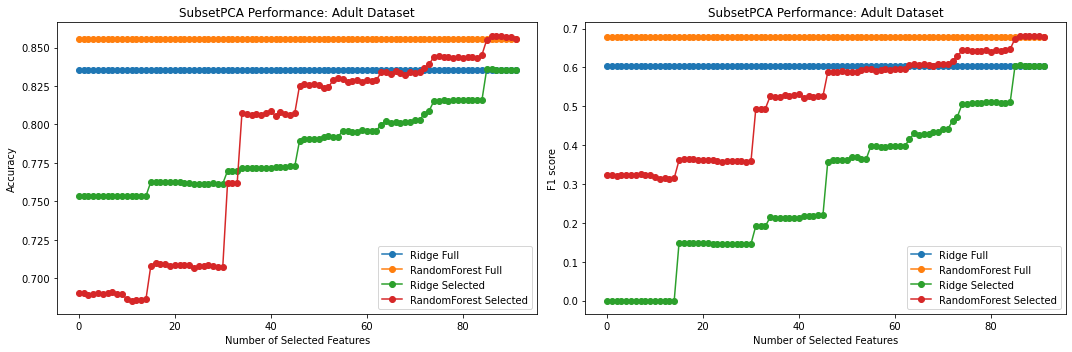

In [13]:
compare(adult_train_X, adult_train_dict_X, adult_train_y, adult_test_X, adult_test_dict_X, adult_test_y, dataset_name='Adult')

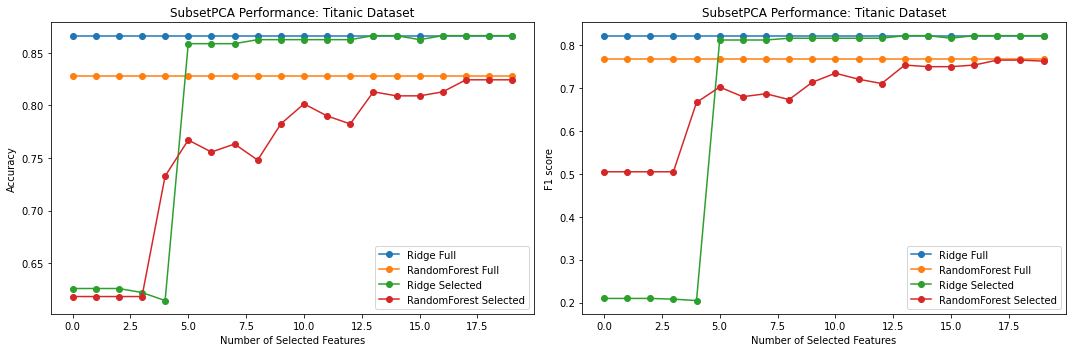

In [14]:
compare(titanic_train_X, titanic_train_dict_X, titanic_train_y, titanic_test_X, titanic_test_dict_X, titanic_test_y, dataset_name='Titanic')

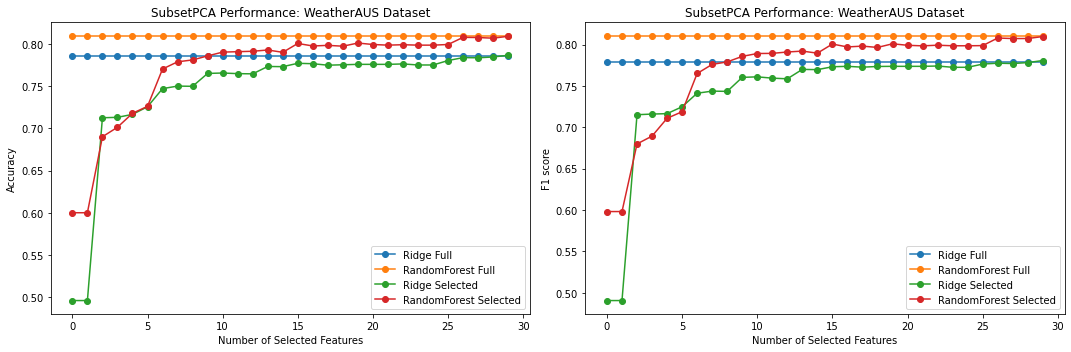

In [15]:
compare(weather_train_X, weather_train_dict_X, weather_train_y, weather_test_X, weather_test_dict_X, weather_test_y, dataset_name='WeatherAUS')

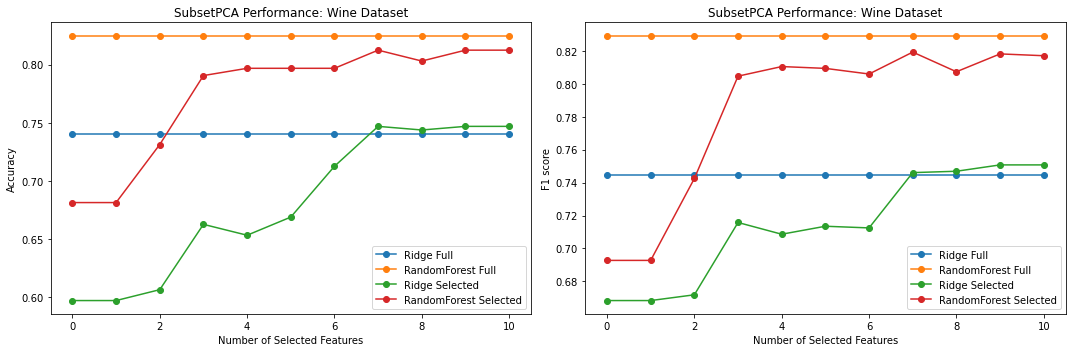

In [16]:
compare(wine_train_X, wine_train_dict_X, wine_train_y, wine_test_X, wine_test_dict_X, wine_test_y, dataset_name='Wine')